# Expectation Maximization


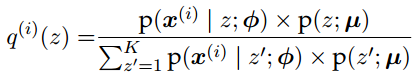

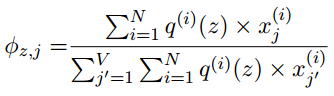

Use expectation-maximization clustering to train a word-sense induction system, applied to the word 'say'.  
• 1.1 Import NLTK, run NLTK.DOWNLOAD() and select SEMCOR. Import SEMCOR from NLTK.CORPUS.  
• 1.2 The command SEMCOR.TAGGED_SENTS(TAG=’SENSE’) returns an iterator over sense-tagged sentences in the corpus. Each sentence can be viewed as an iterator over TREE objects. For TREE objects that are sense-annotated words, you can access the annotation as TREE.LABEL(), and the word itself with TREE.LEAVES(). So SEMCOR.TAGGED_SENTS(TAG=’SENSE’)[0][2].LABEL() would return the sense annotation of the third word in the first sentence.  
• 1.3 Extract all sentences containing the senses SAY.V.01 and SAY.V.02.  
• 2. Build bag-of-words vectors x(i), containing the counts of other words in those sentences, including all words that occur in at least two sentences.  
• 3.1 Implement and run expectation-maximization clustering on the merged data.  
• 3.2 Compute the frequency with which each cluster includes instances of SAY.V.01 and SAY.V.02.

The following code is based on Multinomial distribution. You are free to use another one, like Gaussian distribution.

In [ ]:
!pip install svgling
import svgling

import nltk
nltk.download('semcor')
from nltk.corpus import semcor

import numpy as np
from scipy.stats import multinomial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data]   Package semcor is already up-to-date!


## 1. Extract all sentences containing the senses SAY.V.01 and SAY.V.02.

In [ ]:
from collections import Counter
# get tagged sentences
tagged_sents = semcor.tagged_sents(tag=('sense'))

# tokenize sentences
sentences = []
tokens = set()

# counts of sentences with say.v.01/say.v.02
labels = [] #1/2
labels1_cnt = 0
labels2_cnt = 0

for tagged_sts in tagged_sents:
  lab = []
  sentence = []
  lab_tag = False
  sent_tag = False
  for s in tagged_sts:
    if s.label() == 'say.v.01' or s.label() == 'say.v.02':
      lab.append(s.label())
      sent_tag = True
    else: 
      sentence += s.leaves()

  if not lab_tag and 'say.v.01' in lab:
    labels.append(1)
    labels1_cnt += 1
    lab_tag = True

  if not lab_tag and 'say.v.02' in lab:
    labels.append(2)
    labels2_cnt += 1
    lab_tag = True
  if sent_tag:
    sentences.append(sentence)
    tokens.update(sentence) 

In [ ]:
# show 5 samples
print(labels[:5])

for sts in sentences[:5]:
  print(' '.join(sts))

[1, 1, 1, 2, 2]
The Fulton County Grand Jury Friday an investigation of Atlanta 's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further in term end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
`` Only a relative handful of such reports was received '' , the jury , `` considering the widespread interest in the election , the number of voters and the size of this city '' .
The jury it did find that many of Georgia 's registration and election laws `` are outmoded or inadequate and often ambiguous '' .
The grand jury commented on a number of other topics , among them the Atlanta and Fulton County purchasing departments which it `` are well operated and follow generally accepted practices which inure to the best interest of both governments '' .


In [ ]:
ExpectedOutput='''
[1, 1, 1, 2, 2]
The Fulton County Grand Jury Friday an investigation of Atlanta 's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further in term end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
`` Only a relative handful of such reports was received '' , the jury , `` considering the widespread interest in the election , the number of voters and the size of this city '' .
The jury it did find that many of Georgia 's registration and election laws `` are outmoded or inadequate and often ambiguous '' .
The grand jury commented on a number of other topics , among them the Atlanta and Fulton County purchasing departments which it `` are well operated and follow generally accepted practices which inure to the best interest of both governments '' .'''

## 2. Build bag-of-words vectors x(i), containing the counts of other words in those sentences, including all words that occur in at least two sentences.

In [ ]:
# words that occur in at least two sentences
vocab = []

for token in tokens:
  count = 0
  for sentence in sentences:
    if token in sentence:
      count += 1

      if count >= 2:
        vocab.append(token)
        break


In [ ]:
N = len(sentences)
V = len(vocab)

print('Number of sentences:', N)
print('Size of vocabulary:', V)

print('Number of sentences with say.v.01:', labels1_cnt)
print('Number of sentences with say.v.02:', labels2_cnt)

Number of sentences: 1849
Size of vocabulary: 2760
Number of sentences with say.v.01: 1646
Number of sentences with say.v.02: 203


## Expected Output:  
Number of sentences: 1849  
Size of vocabulary: 2760  
Number of sentences with say.v.01: 1646  
Number of sentences with say.v.02: 203  

In [ ]:
# Create a dictionary to keep track of index of each word
dict_idx = {}

### Your Code Goes Here ###
i = 0
for word in vocab:
    dict_idx[word] = i 
    i += 1

In [ ]:
# Finally, the bag-of-words 2D vector:
X = np.zeros((N,V)) # input data
L = np.zeros(N)     # number of tokens in each line

### Your Code Goes Here ###
for i in range(len(sentences)):
  for token in sentences[i]:
    if token in dict_idx:
      L[i] += 1
      index = dict_idx[token]
      X[i][index] += 1    

## 3. Implement expectation-maximization clustering on the data.  

Thses are the variables used in the following:  

k: the number of clusters: 2  
F: the φ in the formula, shape: (k,V)  
U: the prior expected frequency, shape: (k)  
Q: the posterior probability, p(z|X), shape: (N,k)

In [ ]:
from numpy.random.mtrand import multivariate_normal
# =============================================================================#
'''
Initialize latent parameters.
'''
import numpy as np

def initialize_FU(k):
    ### Your Code Goes Here ###
    U = np.random.random(k)    
    F = np.random.random((k,V))
    sums = sum(U)
    U = U/sums
    for i in range(k):
      sums = sum(F[i])
      F[i] = F[i]/sums

    return F,U


In [ ]:
# =============================================================================#
def calculate_Q(k, F,U):
    '''
    Calculate the soft distribution over clusters for each data point.
    '''
    Q = np.zeros((N,k))
    for z in range(k):
      px = multinomial.pmf(x= X, n= L, p= F[z])
      Q[:,z] = px * U[z] 

    for i in range(N):
      s = sum(Q[i])
      Q[i]/= s
    
    return Q

In [ ]:
# =============================================================================#
def update_FU(k, Q):
    '''
    Update the multinomial distribution parameters F and the cluster prior U.
    '''
    F = np.zeros((k,V))
    U = np.zeros(k)

    ### Your Code Goes Here ###

    for i in range(k):
      for j in range(V):
        F[i][j] = np.dot(Q[:, i], X[:, j])
    
    for i in range(k):
      sums = sum(F[i])
      F[i] = F[i]/sums
    
    for i in range(k):
      U[i] = sum(Q[:,i ])

    sums = sum(U)
    U = U/sums
            
    return F,U

In [ ]:
# =============================================================================#
def em_algorithm(k, iterations):
    F, U = initialize_FU(k)
    ### Your Code Goes Here ###
    for i in range(iterations):
      Q = calculate_Q(k,F,U)
      F, U = update_FU(k,Q) 
        
    return Q, F,U


## 3.1 Run EM clustering on a sample data.

In [ ]:
# save
saveX = X
saveL = L
saveN = N
saveV = V

# sample data
X = np.array([[2,5],
              [4,4],
              [1,8],
              [6,2],
              [8,2]])
L = [7,8,9,8,10]
N = 5
V = 2

# run EM
Q, F,U = em_algorithm(2, 50)

print('U:\n', U)
print('F:\n', F)
print('Q:\n', Q)

# reload
X = saveX
L = saveL
N = saveN
V = saveV

U:
 [0.57409626 0.42590374]
F:
 [[0.69366964 0.30633036]
 [0.21927114 0.78072886]]
Q:
 [[1.11465177e-01 8.88534823e-01]
 [7.61891152e-01 2.38108848e-01]
 [2.38959297e-03 9.97610407e-01]
 [9.95215496e-01 4.78450381e-03]
 [9.99519859e-01 4.80140958e-04]]


In [ ]:
ExpectedOutput='''
U:
 [0.57409618 0.42590382]
F:
 [[0.69366967 0.30633033]
 [0.21927117 0.78072883]]
Q:
 [[1.11465074e-01 8.88534926e-01]
 [7.61890909e-01 2.38109091e-01]
 [2.38959048e-03 9.97610410e-01]
 [9.95215489e-01 4.78451129e-03]
 [9.99519858e-01 4.80141881e-04]]
'''

##3.2 Compute the frequency of each cluster.

In [ ]:
# fix the run
np.random.seed(42)

k = 2
iterations = 50
Q, F,U = em_algorithm(k, iterations)

print('Cluster Frequency:', U)

Cluster Frequency: [0.52027112 0.47972888]


In [ ]:
# compute the cluster assignment accuracy
acc = 0

### Your Code Goes Here ###

for i, q in enumerate(Q):
  if q[0] > q[1] and labels[i] == 1:
    acc += 1
  elif q[0] < q[1] and labels[i] ==2:
    acc += 1

print('Accuracy:', acc/N)

Accuracy: 0.5429962141698216


**Question:** Comment on your result. Is it stable? Why?  
**Answer(1-3 sentences):**  

The result is very unstable. Most of the seed value resulted in NaN values. Seed 2 resulted in an accuracy of ~32%, seed 123 resulted in ~21% accuracy. Since my highest accuracy obeserved was at seed 42 i.e 54% I have fixed my run for that particular seed. The results are unstable mainly because of how the latent paramters (F and U) are initialized.